# Sufficiency

### Imports

In [1]:
import pandas as pd
import numpy as np
import random

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib import patches as mpatches
from mpl_toolkits.basemap import Basemap

import seaborn as sns

import os, sys

import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import pickle

from mpl_toolkits.basemap import Basemap

### Set constants

In [2]:
# Value to change to get correct paths
data_path = 'data/'

In [3]:
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_no_irrig_path = intermediate_path + 'Base/original/'
data_2000_path = intermediate_path + 'Base/with_irrig/'

#data_2050_no_irrig_path = intermediate_path + 'Future_dfs/All_change/'
data_2050_path = intermediate_path + 'Future_dfs/All_change+irrig/'

data_2050_gdp_cont_path = data_2050_path + 'gdp_cont/original/'
data_2050_gdp_income_path = data_2050_path + 'gdp_cat_income/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'

data_2050_gdp_cont_clustered_path = data_2050_path + 'gdp_cont/clustered/'
data_2050_gdp_income_clustered_path = data_2050_path + 'gdp_cat_income/clustered/'
data_2050_gdp_stat_clustered_path = data_2050_path + 'gdp_cat_stat/clustered/'

model_output_path = output_path + 'model_output/'
composite_path = output_path + 'composite/'
compare_path = output_path + 'compare/'
suff_path = output_path + 'sufficiency/'


figure_path = 'figures/with_irrig/'
dist_figures_path = figure_path + 'distributions/'
agg_assumption_fig_path = figure_path + 'agg_assumption/'
cluster_fig_path = figure_path + 'clusters/'
convex_hull_fig_path = figure_path + 'convex_hull/'
suff_fig_path = figure_path + 'sufficiency/'
model_fig_path = figure_path + 'models/'
sensitivity_fig_path = figure_path + 'sensitivity/'

model_path = data_path + 'models/'

In [4]:
files_2050 = os.listdir(data_2050_gdp_cont_path)
files_2050 = [filename for filename in files_2050 if 'ssp' in filename]

climate_models, climate_scenarios = [], []

for file in files_2050:
    if len(file) == 11:
        climate_models.append(file[:2])
        climate_scenarios.append(file[3:7])

climate_models = list(set(climate_models))
climate_models.sort()
climate_scenarios = list(set(climate_scenarios))
climate_scenarios.sort()
climate_models, climate_scenarios

(['cc', 'gs', 'he', 'mr'], ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'])

## Country sufficiency

### Compute

In [5]:
caloric_req = 2320*1e3*365.25

In [6]:
# Population 
def get_total_pop(ssp):
    '''ssp: 2000 or ssp'''
    pop_dir = inputs_path + 'population/'
    pop = pd.read_csv(os.path.join(pop_dir, 'pop_' + ssp + '.csv'))
    pop = pop.set_index('pixel_id')
    pop_tot = pop['gpw_population'].sum()
    return pop_tot

In [7]:
def get_total_prod(ssp):
    '''ssp: 2000 or ssp'''
    results_dir = compare_path
    if ssp == '2000':
        rez = pd.read_csv(os.path.join(results_dir, 'ssp1_compare.csv')) 
        return rez['calories_2000'].sum()
    else:
        rez = pd.read_csv(os.path.join(results_dir, ssp + '_compare.csv'))
        rez = rez.set_index('pixel_id')
        return rez['calories_2050'].sum()

In [8]:
def calc_CalSuff(prod_available, LS, pop,
            caloric_req = (2320*1e3*365.25) #in cal/capita/yr
           ):
    ''' prod_available (for Food not Feed + accounting for losses) - in Calories
        LS : animal calories availables
        pop : in capita
        caloric_req : default values is ADER=2320 kcal/cap/d (without fish)
        
        This is all per year
    '''
    return (prod_available + LS) / (caloric_req * pop)

#### 2000

In [9]:
pctLS_2000 = .19
LS_2000 = 1.1483e15*1e3 #calories

pct_Prod_Food = .52


pop_2000 = get_total_pop('2000')
prod_2000 = get_total_prod('2000') # calories

In [10]:
prod_available = prod_2000*pct_Prod_Food

global_CalSuff_2000 = calc_CalSuff(prod_available,
                       LS_2000,
                       pop_2000)

global_CalSuff_2000

1.9568988529314717

#### 2050

In [11]:
feed_conversion_factor = 2.3

# Data source: Bodirsky : share of calories in diet from animal products
pctLS_2050 = .19 #Assuming cst

In [12]:
def global_CalSuff_2050(ssp,
                        pctLS_2050 = .19):
    
    prod_2050 = get_total_prod(ssp)
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food + feed_now_food
    
    pop = get_total_pop(ssp)

    calsuff = calc_CalSuff(prod_available,
                           LS_2050,
                           pop)
    
    return calsuff

In [13]:
global_CalSuff_2000

1.9568988529314717

In [14]:
for ssp in climate_scenarios:
    print(ssp, global_CalSuff_2050(ssp))

ssp1 1.5100281568141725
ssp2 1.5499055478231056
ssp3 1.2799784767322362
ssp4 1.4471781574422748
ssp5 1.5742578209337597


#### By country 2000

In [49]:
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name']],right_on='base_id',left_on='country_id',how='right')

In [50]:
countries.head()

,country_id,pixel_id,base_id,ISO3,name
0,91.0,330087.0,91,GRL,Greenland
1,91.0,330088.0,91,GRL,Greenland
2,91.0,330089.0,91,GRL,Greenland
3,91.0,330090.0,91,GRL,Greenland
4,91.0,334378.0,91,GRL,Greenland


In [51]:
diet_2000 = pd.read_csv(diet_path + 'Consumption_2000_FAOSTAT.csv')

In [52]:
# LS 2000 Data
LS_2000_df = diet_2000[diet_2000['Item']=='Animal Products'][['Country','Value']].merge(countries[['name','ISO3']].drop_duplicates(),
                                                                                        right_on='name',left_on='Country',how='left')
# kcal/capita/day to cal/capita
LS_2000_df['LS2000_percapita'] = LS_2000_df['Value'].apply(lambda x:x*1e3*365.25)



LS_2000_df = LS_2000_df[['name','ISO3','LS2000_percapita']].set_index('ISO3')

In [53]:
# Population by country
pop_dir = pop_path
pop = pd.read_csv(os.path.join(pop_dir,'pop_2000.csv'))
pop = pop.merge(countries,right_on='pixel_id',left_on='pixel_id')
pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()

# Production by country
prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'))
prod = prod.merge(countries,right_on='pixel_id',left_on='pixel_id')
prod_bycountry = prod.groupby('ISO3')['calories_2000'].sum()

In [54]:
countries_list = pop_bycountry[pop_bycountry>0].index

In [55]:
calsuff_numerator = 0
pct_Prod_Food_2000 = .52

for country in countries_list:
    # Production
    try:
        prod_bycountry[country]
    except KeyError:
        prod_country = 0
    else:
         prod_country =  prod_bycountry[country]
            
    # LS 2000
    try:
        LS2000 = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry[country]
    except KeyError:
        LS2000 = 0
    
    # Caloric sufficiency's numerator
    calsuff_numerator += ((prod_country * pct_Prod_Food_2000)+LS2000)
    

global_calsuff_2000 = calsuff_numerator/(caloric_req*pop['gpw_population'].sum())
global_calsuff_2000

9.637975551804606e+18


1.903160631483274

#### By country 2050

In [43]:
def calc_CalSuff_numerator_2050(LS_2000,
                      pct_LS_2050,
                      prod_2050):
    
    LS_2050 = pct_LS_2050 * (prod_2050*pct_Prod_Food_2000 + feed_conversion_factor*LS_2000) / (1 + pct_LS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food_2000 + feed_now_food
    
    return (prod_available+LS_2050)

In [62]:
# Load diets data
diets = pd.read_csv(diet_path + 'pctLS_SSPs_Bodirsky.csv',sep=';')

for ssp in climate_scenarios:

    # Population by country
    pop_dir = pop_path
    pop = pd.read_csv(os.path.join(pop_dir, 'pop_'+ssp+'.csv'))
    pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
    pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()

    # Production by country
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'))
    prod = prod.merge(countries, right_on='pixel_id',left_on='pixel_id')
    prod_bycountry = prod.groupby('ISO3')['calories_2050'].sum()
    
    calsuff_numerator = 0
    
    for country in countries_list:
        # Diet 
        try:
            pct_LS_2050 = diets[(diets['Scenario'] == ssp) & (diets['Region'] == country)]['2050'].values[0]
        except IndexError:
            pct_LS_2050 = 0

        # Production
        try:
            prod_country = prod_bycountry[country]
        except KeyError:
            prod_country = 0
                
                
        # LS 2000
        try:
            LS2000 = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry[country]
        except KeyError:
            LS2000 = 0

        # Caloric sufficiency
        calsuff_numerator += calc_CalSuff_numerator_2050(LS_2000,
                                                          pct_LS_2050,
                                                          prod_2050=prod_country)
    print(calsuff_numerator)
    global_calsuff_2050 = calsuff_numerator/(caloric_req*pop['gpw_population'].sum())
    print('Global CalSuff in '+ssp+' :', global_calsuff_2050)

5.0328660910649796e+20
Global CalSuff in ssp1 : 74.70919221508937
5.0885678529718616e+20
Global CalSuff in ssp2 : 73.13797244730272
5.168827286649923e+20
Global CalSuff in ssp3 : 61.43196905533374
5.146777050157124e+20
Global CalSuff in ssp4 : 69.62939741750812
5.028179598168556e+20
Global CalSuff in ssp5 : 71.94134053045794


In [64]:
prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'))
prod['calories_2000'].sum(), prod['calories_2050'].sum()

(1.6849646838209243e+19, 1.931534421373288e+19)

In [65]:
(prod['calories_2050'].sum() - prod['calories_2000'].sum())/prod['calories_2000'].sum()

0.14633525552193047

# For after

In [61]:
country_ids = pd.read_csv(inputs_path + 'Base/country_names.csv', header=0, index_col='pixel_id')
sufficiencies = pd.DataFrame()

# calorie needs for 1 person
caloric_req = 2320 * 1e3 * 365.25 #in cal/capita/yr

for ssp in climate_scenarios:
    print(ssp)
    df = pd.read_csv(compare_path + '{}_compare.csv'.format(ssp), index_col='pixel_id')
    if ssp == 'ssp1':
        cal_2000 = df.groupby('country_id')['calories_2000'].sum()
        pop_2000 = df.groupby('country_id')['population_2000'].sum()
        sufficiencies['2000'] = cal_2000 / pop_2000 / cal_needs_per_person
        
    cal = df.groupby('country_id')['calories_2050'].sum()
    pop = df.groupby('country_id')['population_2050'].sum()
    sufficiencies[ssp] = cal / pop / cal_needs_per_person
    sufficiencies['delta_suff_' + ssp] = (sufficiencies[ssp] - sufficiencies['2000']) / sufficiencies['2000']
    
sufficiencies.to_csv(suff_path + 'country_sufficiencies.csv')
sufficiencies.head()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ssp1
ssp2
ssp3
ssp4
ssp5


,2000,ssp1,delta_suff_ssp1,ssp2,delta_suff_ssp2,ssp3,delta_suff_ssp3,ssp4,delta_suff_ssp4,ssp5,delta_suff_ssp5
country_id,,,,,,,,,,,
1,1.263923,0.915397,-0.275749,0.762730,-0.396538,0.574296,-0.545624,0.510265,-0.596285,1.238429,-0.020170
2,1.008154,0.971264,-0.036592,1.321533,0.310844,0.775203,-0.231067,1.279487,0.269138,1.616012,0.602941
4,3.846604,5.384442,0.399791,5.121857,0.331527,5.042131,0.310801,5.314248,0.381543,5.190569,0.349390
5,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
6,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN


### Vizualize sufficiency

In [115]:
def visualize_sufficiency(suff, scenario, min_val, max_val, fig, ax, title, shape=(2160, 4320), savefig=False):
    # Set values to 
    suff_array = np.zeros((shape[0]*shape[1],)) - 1
    suff_array[suff.index] = suff.values
    suff_df = pd.DataFrame(suff_array, columns=['label'])
    
    #c = cm.PuBu(np.linspace(0.2, 1))
    #cmap = colors.LinearSegmentedColormap.from_list('name', c)
    #cmap = cm.PuBu
    cmap = cm.spring
    cmap.set_under(color='white')
    cmap.set_over('red')
    
    over = mpatches.Patch(color='red', label='Less than 100%')
    
    #Plot data
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, vmin=min_val, vmax=max_val, ax=ax)
    #im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, vmin=0,ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    cb = fig.colorbar(im, ax=ax)
    cb.set_label('Sufficiency (%)')
    plt.legend(handles=[over])
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + scenario + '.png', dpi=500)

ssp1
ssp2
ssp3
ssp4
ssp5


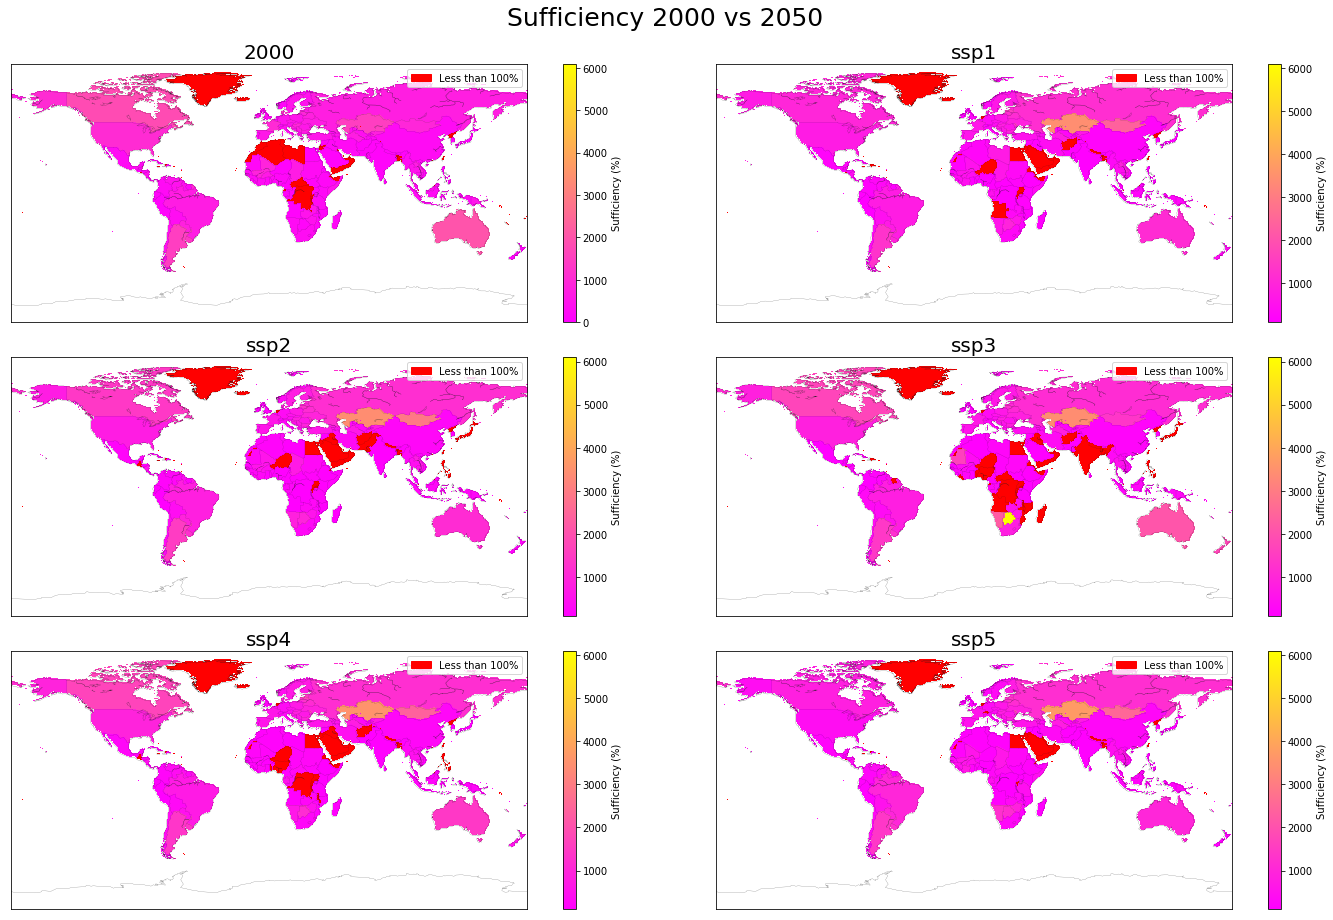

In [169]:
fig = plt.figure(figsize=(20, 13))
fig.suptitle('Sufficiency 2000 vs 2050', fontsize=25)

sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv', index_col='country_id')[climate_scenarios+['2000']]
min_val, max_val = 100*sufficiencies.min().min(), 100*sufficiencies.max().max()

for i, ssp in enumerate(climate_scenarios): 
    print(ssp)
    df = pd.read_csv(compare_path + '{}_compare.csv'.format(ssp), index_col='pixel_id', na_values=[-9999])
    if ssp == 'ssp1':
        title_2000 = '2000'
        ax = plt.subplot(321)
        suff_2000 = pd.merge(df['country_id'], sufficiencies['2000'], left_on='country_id', right_index=True)['2000']
        #cut = pd.cut(suff_2000*100, bins=suff_thresholds, labels=range(len(suff_thresholds)-1))
        suff_2000[suff_2000 < 1] = 2*max_val
        visualize_sufficiency(suff_2000*100, ssp, min_val, max_val, fig, ax, title_2000, savefig=False)

    ax = plt.subplot(321 + i + 1)
    title = ssp
    suff = pd.merge(df['country_id'], sufficiencies[ssp], left_on='country_id', right_index=True)[ssp]
    suff[suff < 1] = 2*max_val
    #cut = pd.cut(suff*100, bins=suff_thresholds, labels=range(len(suff_thresholds)-1))
    visualize_sufficiency(suff*100, ssp, 100, max_val, fig, ax, title, savefig=False)
    
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(suff_fig_path + 'sufficiencies' + '.png', dpi=500)

In [139]:
suff_thresholds = [0, 90, 100, 200, 500, 1000, np.inf]

(<matplotlib.axes._subplots.AxesSubplot at 0x2037673cf8>,
 array([   0.,   90.,  100.,  200.,  500., 1000.,   inf]))

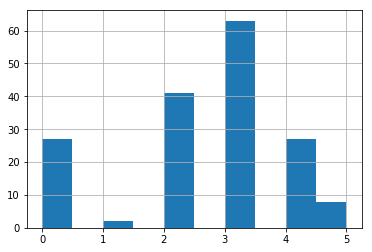

In [140]:
cut, b = pd.cut(sufficiencies['2000']*100, bins=suff_thresholds, labels=range(len(suff_thresholds)-1), retbins=True)
cut.hist(), b

### Visualize delta sufficiency

In [142]:
def visualize_changes_suff(delta_suff, scenario, min_val, max_val, fig, ax, title, shape=(2160, 4320), savefig=False):
    
    # Set values to 
    suff_array = np.zeros((shape[0]*shape[1],)) - 9999
    suff_array[delta_suff.index] = delta_suff.values
    suff_df = pd.DataFrame(suff_array, columns=['label'])
    
    data = suff_df.values
    #data = np.ma.masked_where(data == 0, data)
    cmap = cm.coolwarm_r
    cmap.set_under('white')
    cmap.set_over('orange')
    
    over = mpatches.Patch(color='orange', label='Over +100%')
    
    #Plot data
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, vmin=min_val, vmax=max_val, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    cb = fig.colorbar(im, ax=ax)
    cb.set_label('Sufficiency difference (%)')
    plt.legend(handles=[over])
    if savefig != False:
        fig.savefig(suff_fig_path + 'delta_suff_'+ scenario + '.png', dpi=500)

ssp1


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


ssp2
ssp3
ssp4
ssp5


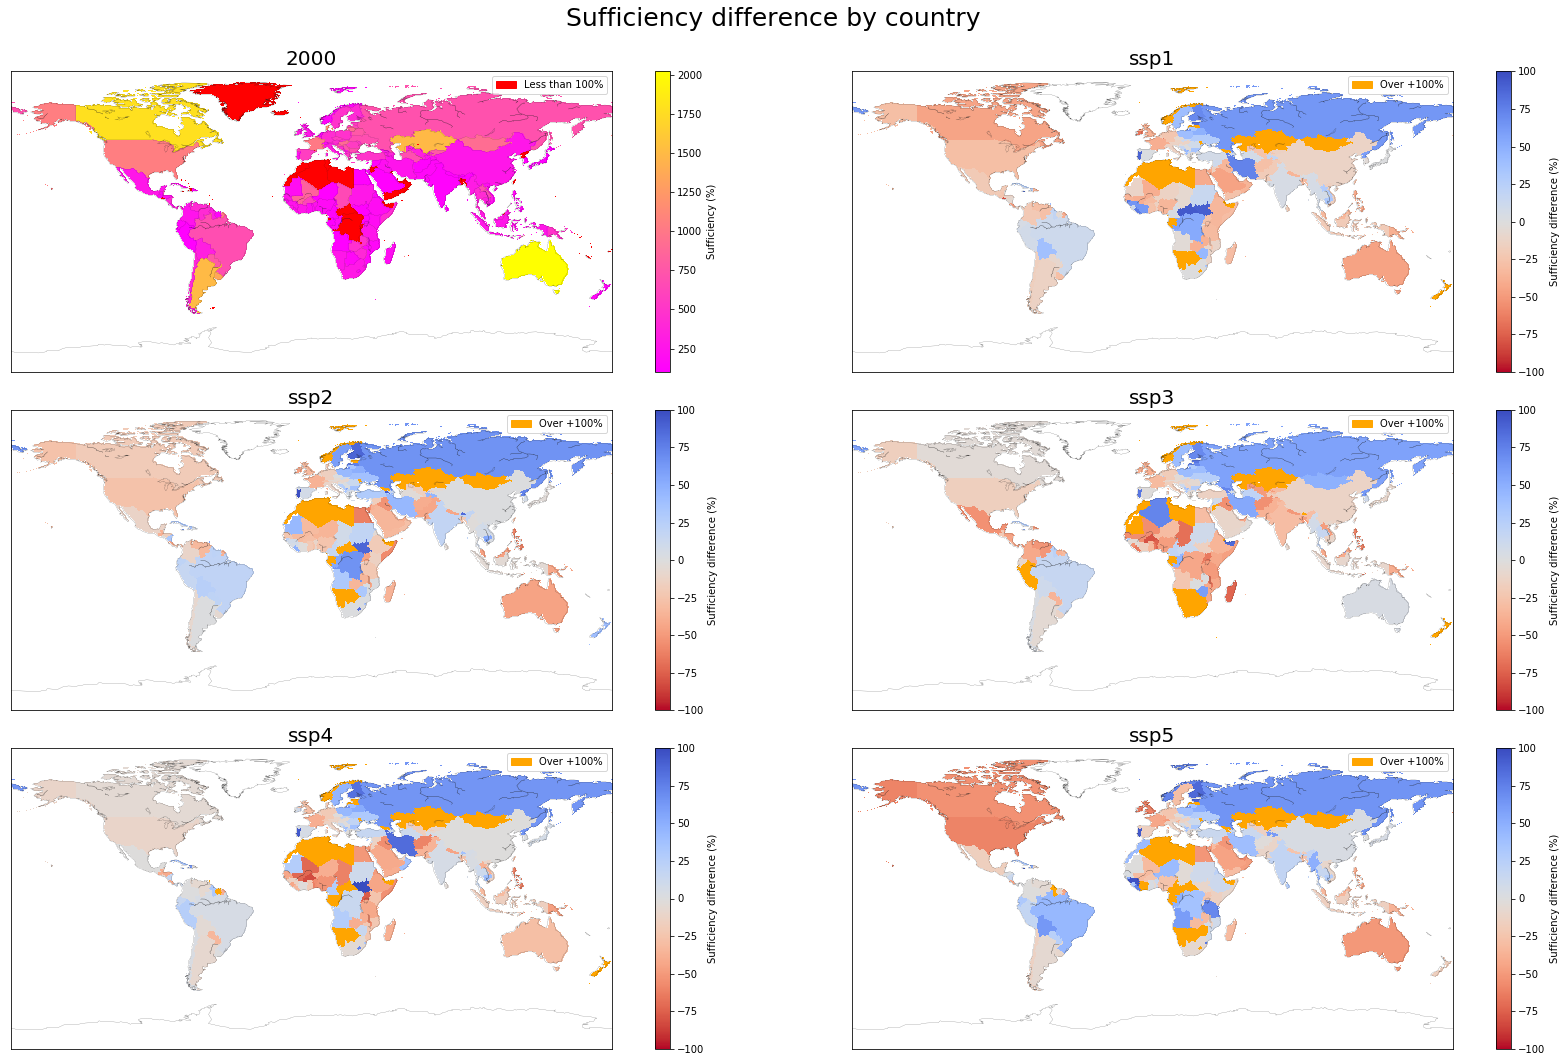

In [170]:
fig = plt.figure(figsize=(24, 15))
fig.suptitle('Sufficiency difference by country', fontsize=25)

ax = plt.subplot(321)

sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv', index_col='country_id')

min_val, max_val = -100, 100

for i, ssp in enumerate(climate_scenarios): 
    print(ssp)
    df = pd.read_csv(compare_path + '{}_compare.csv'.format(ssp), index_col='pixel_id', na_values=[-9999])
    
    if ssp == 'ssp1':
        title_2000 = '2000'
        ax = plt.subplot(321)
        suff_2000 = pd.merge(df['country_id'], sufficiencies['2000'], left_on='country_id', right_index=True)['2000']
        min_2000, max_2000 = suff_2000.min()*100, suff_2000.max()*100
        suff_2000[suff_2000 < 1] = 2*suff_2000.max()
        #cut = pd.cut(suff_2000*100, bins=suff_thresholds, labels=range(len(suff_thresholds)-1))
        visualize_sufficiency(suff_2000*100, ssp, 100, max_2000, fig, ax, title_2000, savefig=False)

    
    suff = pd.merge(df['country_id'], sufficiencies['delta_suff_'+ssp], left_on='country_id', right_index=True)['delta_suff_'+ssp]

    ax = plt.subplot(321 + i + 1)

    title = ssp
    visualize_changes_suff(suff*100, ssp, min_val, max_val, fig, ax, title, savefig=False)
    

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(suff_fig_path + 'delta_suff' + '.png', dpi=500)